<a href="https://colab.research.google.com/github/antonelladamico17/Market-Basket-Analysis/blob/main/Algorithm_for_massive_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Antonella D'Amico, Luca Romano
## **Project of Algorithms for Massive Data**
#### Market Bakset Analisys on IMDB dataset


# Download

#### Kaggle API

In [ ]:
#upload kaggle.json 

from google.colab import files
files.upload()

In [2]:
#set directory 
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

#### Spark

In [3]:
#Install java and spark
!sudo apt update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://apache.osuosl.org/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz 
!tar xf spark-3.1.1-bin-hadoop3.2.tgz 
!pip install -q findspark

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:11 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [61.8 kB]
Hit:12 http://ppa.launchpad.net/cran/

In [4]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

In [5]:
!pip install pyspark

     |████████████████████████████████| 212.4MB 61kB/s 
     |████████████████████████████████| 204kB 17.9MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.2-py2.py3-none-any.whl size=212880768 sha256=ca6ba53f0f6279434b5894eb6c8916569cafabd4c849e00a2afad65fd0f0fb97
  Stored in directory: /root/.cache/pip/wheels/40/1b/2c/30f43be2627857ab80062bef1527c0128f7b4070b6b2d02139
Successfully built pyspark


In [6]:
# Check the pyspark version
import pyspark
print(pyspark.__version__)

3.1.2


In [7]:
# Pyspark's functions import
from pyspark.sql import functions as f
from pyspark import SparkContext, SparkConf
from pyspark.sql.functions import collect_set, col
from pyspark import StorageLevel
from pyspark.ml.fpm import FPGrowth

In [8]:
import findspark
findspark.init()

In [9]:
#initialize spark context object
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
conf = SparkConf().setAppName("mba")
spark = SparkSession.builder.enableHiveSupport().config(conf = conf).getOrCreate()
sc = spark.sparkContext

#### Data Import

In [10]:
#Download the IMDB dataset from kaggle using the json file uploaded before
!chmod 600 /content/kaggle.json
!kaggle datasets download -d ashirwadsangwan/imdb-dataset

100% 1.44G/1.44G [00:12<00:00, 105MB/s] 
100% 1.44G/1.44G [00:12<00:00, 124MB/s]


In [11]:
#unzip the file and remove the zip
!unzip \*.zip && rm *.zip  

Archive:  imdb-dataset.zip
  inflating: name.basics.tsv.gz      
  inflating: name.basics.tsv/name.basics.tsv  
  inflating: title.akas.tsv.gz       
  inflating: title.akas.tsv/title.akas.tsv  
  inflating: title.basics.tsv.gz     
  inflating: title.basics.tsv/title.basics.tsv  
  inflating: title.principals.tsv.gz  
  inflating: title.principals.tsv/title.principals.tsv  
  inflating: title.ratings.tsv.gz    
  inflating: title.ratings.tsv/title.ratings.tsv  


In [12]:
# loading into spark
titlePrincipals = spark.read.csv("/content/title.principals.tsv/title.principals.tsv", sep = "\t", inferSchema="true", header="true")
titleBasics = spark.read.csv("/content/title.basics.tsv/title.basics.tsv", sep= "\t", inferSchema= "true", header="true")

In [13]:
# creating views for SQL querying 
titlePrincipals.createOrReplaceTempView("titlePrincipals")
titleBasics.createOrReplaceTempView("titleBasics")

# Preprocessing

In [14]:
# titlePrincipals filtered over column category to extract actors and actresses
actor = """ SELECT *
            FROM titlePrincipals
            WHERE (category = 'actor') OR (category = 'actress')
        """
actor = spark.sql(actor)
actor.show(5)

+---------+--------+---------+--------+---+----------------+
|   tconst|ordering|   nconst|category|job|      characters|
+---------+--------+---------+--------+---+----------------+
|tt0000005|       1|nm0443482|   actor| \N|  ["Blacksmith"]|
|tt0000005|       2|nm0653042|   actor| \N|   ["Assistant"]|
|tt0000007|       1|nm0179163|   actor| \N|              \N|
|tt0000007|       2|nm0183947|   actor| \N|              \N|
|tt0000008|       1|nm0653028|   actor| \N|["Sneezing Man"]|
+---------+--------+---------+--------+---+----------------+
only showing top 5 rows



In [15]:
# titleBasics filtered over column titleType to extract only movies
movie = """ SELECT *
            FROM titleBasics
            WHERE titleType = 'movie'
        """
movie = spark.sql(movie)
movie.show(5)

+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+
|   tconst|titleType|        primaryTitle|       originalTitle|isAdult|startYear|endYear|runtimeMinutes|              genres|
+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+
|tt0000009|    movie|          Miss Jerry|          Miss Jerry|      0|     1894|     \N|            45|             Romance|
|tt0000147|    movie|The Corbett-Fitzs...|The Corbett-Fitzs...|      0|     1897|     \N|            20|Documentary,News,...|
|tt0000335|    movie|Soldiers of the C...|Soldiers of the C...|      0|     1900|     \N|            \N|     Biography,Drama|
|tt0000502|    movie|            Bohemios|            Bohemios|      0|     1905|     \N|           100|                  \N|
|tt0000574|    movie|The Story of the ...|The Story of the ...|      0|     1906|     \N|            70|Biography,Crim

In [17]:
# Baskets 
query = """ SELECT tp.tconst, tp.nconst
            FROM titlePrincipals AS tp LEFT JOIN titleBasics as tb ON tp.tconst == tb.tconst                       
            WHERE (tp.category == 'actor' OR tp.category == 'actress')  AND tb.titleType == 'movie'
            """
data = spark.sql(query)
baskets = data.groupBy('tconst').agg(collect_set('nconst').alias('nconst'))
baskets.createOrReplaceTempView('baskets')
baskets.show(5)

+---------+--------------------+
|   tconst|              nconst|
+---------+--------------------+
|tt0002591|[nm0029806, nm050...|
|tt0003689|[nm0910564, nm052...|
|tt0004272|[nm0368875, nm009...|
|tt0004336|[nm0268437, nm081...|
|tt0005209|[nm0593671, nm039...|
+---------+--------------------+
only showing top 5 rows



In [18]:
#create RDD actors_basket which takes only the list of actors without taking into account the title of the film
actors_baskets = baskets.select('nconst').rdd.flatMap(list) 
print(actors_baskets.collect()[:3])

[['nm0029806', 'nm0509573'], ['nm0910564', 'nm0527801', 'nm0399988', 'nm0101071', 'nm0694718', 'nm0728289', 'nm0585503'], ['nm0368875', 'nm0092665', 'nm0492302', 'nm0445507', 'nm0776747', 'nm0383278', 'nm0192062', 'nm0285643', 'nm0793189']]


# A Priori

In [ ]:
from itertools import combinations, product
import pandas as pd
import matplotlib.pyplot as plt
import collections
import time

#### A priori function

In [ ]:
#define a function that generates singletons from an rdd of couples, triples etc. 
#returns the singletons and their occurrencies
def create_singletons (rdd): 
  #generates a list of actors, map them to 1 to initialize the counter for each 
  #actor and update the counter for every occurrence
  singletons = rdd.flatMap(list) \
                  .map(lambda item: (item, 1)) \
                  .reduceByKey(lambda x, y: x+y)
  return(singletons)

In [ ]:
#define a function that takes an rdd (items) containing the result of the 
#function apriori at step i-1, and the index i which indicates the size of the 
#combinations of actors (starts from i=3 for triples and so on). The function
#generates the singletons from "items" and evaluate the carthesian product 
#between "items" and the singletons.
#returns the combinations which have size = i removing every possible permutation

def new_combinations(items, i):
  #removes the counter from each item. each item in items is in the form 
  #example: ((actor1, actor2),2)
  items = items.map(lambda item: list(item[0])) 
  #generate singletons from each item in items
  singleton = create_singletons(items).map(lambda item: [item[0]]) 
  #initialize an empty list that will contain the new possible combinations
  items_set = [] 
  #for cicle generates the new combinations using the carthesian product between 
  #items and singletons. the result will be like [[item],[singleton]]
  for comb in list(product(items.toLocalIterator(), singleton.toLocalIterator())): 
    #merges the two lists into a "new item" with form "new item"=[item, singleton]
    comb = comb[0]+comb[1] 
    #takes the set of each combination and orders it to prevent permutations to
    #be counted as different item and to remove the repetitions of actors
    comb_set = sorted(set().union(comb))
    #if the set have size == i and was not already included in items_set
    #then it is added to items_set
    if (len(comb_set) == i) and comb_set not in items_set: 
        items_set.append(comb_set) #popoliamo items_set
  return(items_set)

In [ ]:
#define the apriori function, takes as parameters an rdd of baskets (just the 
#actors) and the minumum support (threshold) to evaluate the frequent pairs, 
#triples etc. 
#returns an rdd (support) containing all the frequent items and their occurrencies

def apriori(actor_baskets, threshold): 
  #generate singletons 
  singleton = create_singletons(actor_baskets) \
              .filter(lambda item: item[1] >= threshold) \
              .map(lambda item: (item[0])) 
  #find the possible pairs            
  possible_combinations = list(combinations(singleton.toLocalIterator(),2)) 
  #initialize support as empty rdd
  support = sc.parallelize([]) 
  #cache the rdd for better perfomance, it is reused multiple times
  actor_baskets.cache()
  i=3 #starts at 3 since we already found the pairs
  #cicles until possible combinations are found
  while len(possible_combinations)>0: 
    #chek whether the possible items are frequent in the dataset
    frequent_items = actor_baskets.flatMap(lambda cast: [(tuple(item), 1) for item in possible_combinations if set(list(item)).issubset(set(cast))]) \
                    .reduceByKey(lambda x, y: x+y) \
                    .filter(lambda item: item[1] >= threshold)
    #add the frequent items and their occurrencies to support rdd
    support = support.union(frequent_items) 
    #generates new items from the last frequent items found using the function defined above
    possible_combinations = new_combinations(frequent_items, i) 
    #increment i
    i += 1  
    
  #remove actor_baskets from cache
  actor_baskets.unpersist()
  return (support)

#### Results

In [ ]:
#compute the Minimum Support using 0.0003 as fraction of the number of baskets
#in order for pairs, triple etc. to be considered frequent 
count = actors_baskets.count()
threshold = count*0.0003
print(count, threshold)

393654 118.0962


In [ ]:
#Output of A-Priori on all baskets with 119 as minimum support
print(apriori(actors_baskets, threshold).collect())

[(('nm0623427', 'nm0006982'), 237), (('nm0006982', 'nm0619779'), 122), (('nm0006982', 'nm0419653'), 162), (('nm0046850', 'nm0006982'), 169), (('nm2082516', 'nm0648803'), 147), (('nm2373718', 'nm0648803'), 126)]


In [ ]:
#SAMPLING for ratio threshold over time
#the output is given by considering a sample of baskets with size 25% of the
#total. we aim at analyzing the time behaviour of the algorithm by varying the 
#minimum support.

#generate the sample
sample = actors_baskets.sample(False, 0.25, seed = 11) 
#intialize a list which will contain the elaped time for each threshold
elapsed = []
#initialize a list which will contain the frequent items for each threshold 
frequent = []
#save the number of baskets after the sampling to compute the minimum support 
count = sample.count()
#will contain the support size in the format t*0,0001
threshold_ap = [] 
for t in range(3,9):
  #save the start time
  start = time.time() 
  #compute the support size
  threshold_i = t*0.0001 
  threshold_ap.append(threshold_i) 
  #perform apriori on the sample using as support threshold_i*count and collects
  #the frequent items
  frequent.append(list(apriori(sample, threshold_i*count).collect()))
  #saves the end time 
  end = time.time()
  #evaluate the elapsed time 
  interval = end - start
  elapsed.append(interval) 
  


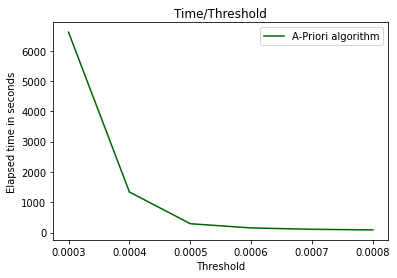

In [ ]:
#apriori plot for threshold size between 0.0003 and 0.0008 on 25% size sample

time_threshold_ratio = pd.DataFrame()
time_threshold_ratio['Elapsed_time'] = elapsed
time_threshold_ratio['Threshold'] = threshold_ap
plt.plot(time_threshold_ratio['Threshold'], time_threshold_ratio['Elapsed_time'],
         label = 'A-Priori algorithm', color = '#006400')
plt.xlabel('Threshold')
plt.ylabel('Elapsed time in seconds')
plt.savefig('time_threshold_ratio.jpg')
plt.legend()
plt.title('Time/Threshold')
plt.show()

In [ ]:
#SAMPLING for ratio size over time with fixed threshold 0.0003

elapsed2 = [] 
frequent2 = []
for t in range(1,4): 
  print(t) 
  start = time.time()
  #compute the sample for each cycle
  sample = actors_baskets.sample(False, t/10, seed = 11) 
  count = sample.count()
  #compute apriori on the sample with 0.0003*number of baskets in the sample as minimum support
  frequent = list(apriori(sample, 0.0003*count).collect()) 
  frequent2.append(frequent) 
  #save end time
  end = time.time()
  #compute end time
  interval = end - start
  elapsed2.append(interval) 

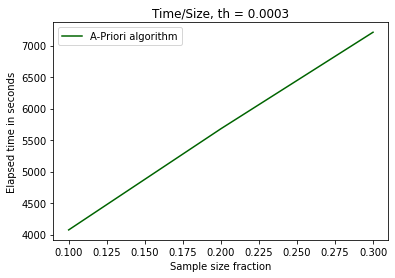

In [ ]:
#plot time over number of baskets with fixed threshold
time_size_ratio = pd.DataFrame()
time_size_ratio['Elapsed_time'] = elapsed2
time_size_ratio['Size'] = range(1,4)
time_size_ratio['Size'] = time_size_ratio['Size'].div(10) #size is fraction 0.10-0.50 -> 10%-50% of the total
plt.plot(time_size_ratio['Size'], time_size_ratio['Elapsed_time'], label = 'A-Priori algorithm', color = '#006400')
plt.xlabel('Sample size fraction')
plt.ylabel('Elapsed time in seconds')
plt.savefig('time_size_ratio1.jpg')
plt.legend()
plt.title('Time/Size, th = 0.0003')
plt.show()

# FP - Growth

In [ ]:
#import fp-growth and compute it on all baskets 
start_compl = time.time()
fpG_compl = FPGrowth(itemsCol="nconst", minSupport=0.0003)
start_compl = time.time()
fpG_compl = fpG_compl.fit(baskets)
print(time.time() - start_compl)

229.64582204818726


In [ ]:
#print first 10 frequent items
fpG_compl.freqItemsets.show(10)

+-----------+----+
|      items|freq|
+-----------+----+
|[nm1388202]| 153|
|[nm0430646]| 120|
|[nm0103977]| 798|
|[nm0006982]| 585|
|[nm0436922]| 152|
|[nm0408381]| 120|
|[nm0648803]| 565|
|[nm0405977]| 152|
|[nm0576495]| 120|
|[nm0579663]| 120|
+-----------+----+
only showing top 10 rows



In [ ]:
#create SQL view for querying
fpG_compl = fpG_compl.freqItemsets
fpG_compl.createOrReplaceTempView("fpG_compl")

In [ ]:
q = """SELECT *
       FROM fpG_compl
       WHERE size(items) >= 2
       ORDER BY freq DESC
    """
spark.sql(q).show(10)

+--------------------+----+
|               items|freq|
+--------------------+----+
|[nm0623427, nm000...| 237|
|[nm0046850, nm000...| 169|
|[nm0419653, nm000...| 162|
|[nm2082516, nm064...| 147|
|[nm2373718, nm064...| 126|
|[nm0619779, nm000...| 122|
+--------------------+----+



In [ ]:
#compute fp-growth algorithm's time elapsed with different thresholds
time_fpG = []
threshold_fpG = []
sample_fpG = baskets.sample(False, 0.25, seed = 11) 
for t in range(3,9):
  start = time.time()
  threshold_j = t*0.0001
  fpG = FPGrowth(itemsCol="nconst", minSupport = threshold_j)
  fpG = fpG.fit(sample_fpG)
  threshold_fpG.append(threshold_j)
  end = time.time()
  interval = end - start
  time_fpG.append(interval)

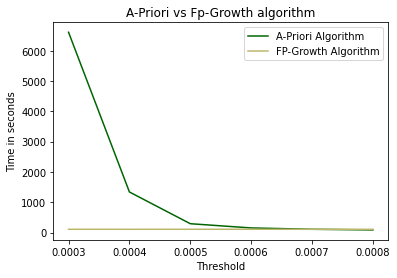

In [ ]:
#Plot performances of Apriori and FP-Growth by varying thresholds both on 25% sample size baskets  
x_ap = threshold_ap
y_ap = elapsed
plt.plot(x_ap, y_ap,
         label="A-Priori Algorithm",
         color = '#006400')

x_fpG = threshold_fpG
y_fpG = time_fpG
plt.plot(x_fpG, y_fpG,
         label="FP-Growth Algorithm",
         color = '#BDB76B')

plt.xlabel("Threshold")
plt.ylabel("Time in seconds")
plt.title('A-Priori vs Fp-Growth algorithm')

leg = plt.legend()
plt.savefig("Apriori vs fp time threshold")
plt.show()

In [ ]:
#Measure time-sample size relation in FP-growth 
time_fpG = []
threshold_fpG = []
for t in range(1,4):
  start = time.time()
  sample_fpG = baskets.sample(False, t/10, seed = 11) 
  fpG = FPGrowth(itemsCol="nconst", minSupport = 0.0003)
  fpG = fpG.fit(sample_fpG)
  end = time.time()
  interval = end - start
  time_fpG.append(interval)

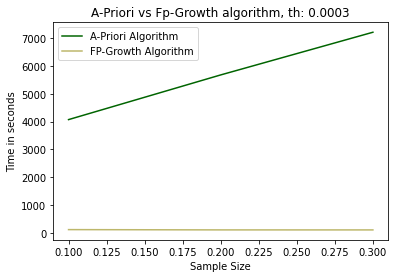

In [ ]:
#Plot time-sample size plots to compare scalability between the 2 algorithms
x = [0.1, 0.2, 0.3] 
plt.plot(time_size_ratio['Size'], time,
         label="A-Priori Algorithm",
         color = '#006400')

y_fpG = time_fpG
plt.plot(x, time_fpG,
         label="FP-Growth Algorithm",
         color = '#BDB76B')

plt.xlabel("Sample Size")
plt.ylabel("Time in seconds")
plt.title('A-Priori vs Fp-Growth algorithm, th: 0.0003')

leg = plt.legend()
plt.savefig("Apriori vs fp time samplesize")
plt.show()